In [1]:
# https://github.com/LukeDitria/pytorch_tutorials/blob/main/section04_pytorch_cnn/notebooks/Tutorial_Convolutions.ipynb

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T

from PIL import Image
from tqdm.notebook import trange, tqdm

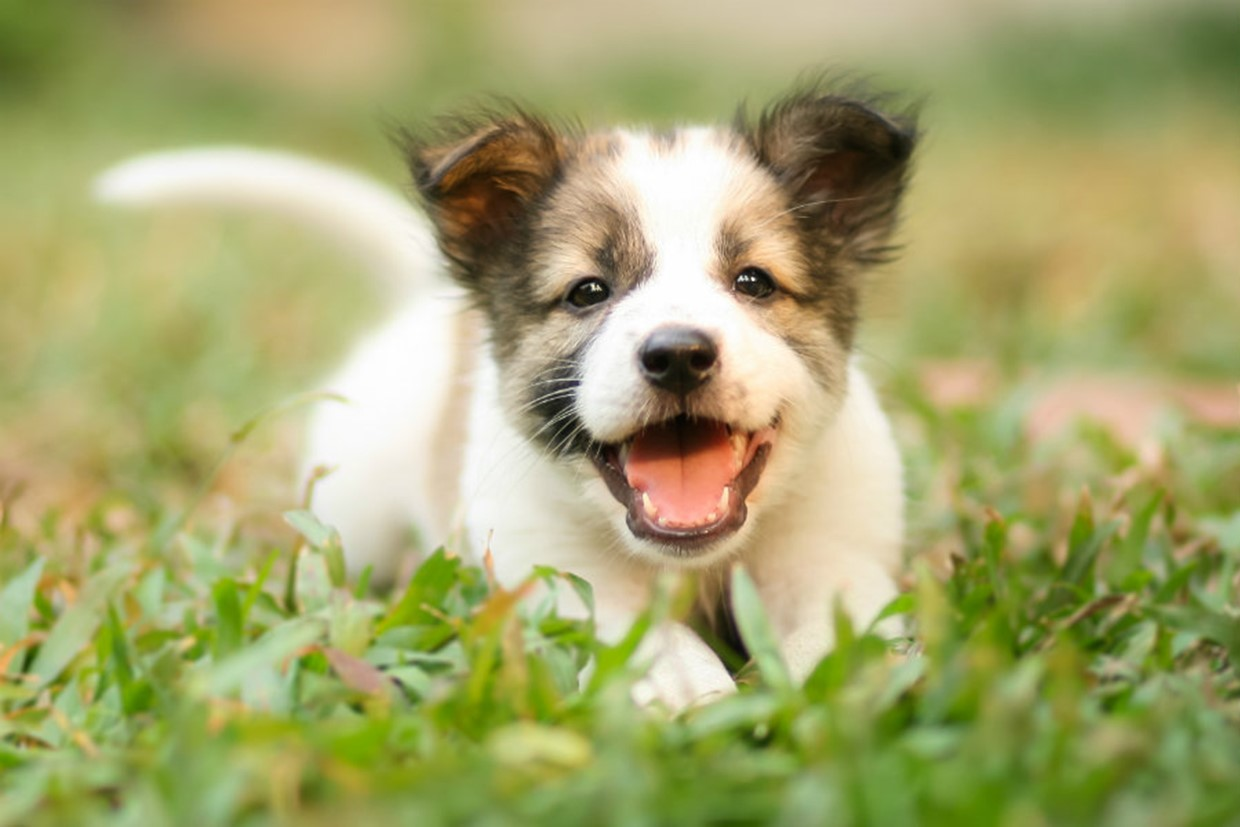

In [3]:
img = Image.open('../data/puppy.jpg')
img

In [4]:
transform = T.ToTensor()
resize = T.Resize(512)

img_tensor = transform(resize(img))
print(img_tensor.shape)

torch.Size([3, 512, 767])


**Hand Crafted Convolution Kernels**

In [5]:
# https://en.wikipedia.org/wiki/Sobel_operator
#  The naming convention gx suggests it is a gradient in the x-direction
gx = torch.FloatTensor([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]).unsqueeze(0)
gx = torch.repeat_interleave(gx, 3, 0).unsqueeze(0)
print(gx.shape)
print(gx)

torch.Size([1, 3, 3, 3])
tensor([[[[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]]]])


In [6]:
gy = torch.FloatTensor([[1, 2, 1],[0, 0, 0],[-1, -2, -1]]).unsqueeze(0)
gy = torch.repeat_interleave(gy, 3, 0).unsqueeze(0)
print(gy.shape)
print(gy)

torch.Size([1, 3, 3, 3])
tensor([[[[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]],

         [[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]],

         [[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]]]])


For the function Conv2d (which performs the convolution operation) the convolutional kernel must be of the shape
[out channels, in channels, kernel height, kernel width]
The input image must have the shape
[minibatch size, in channels, image height, image width]

torch.Size([1, 1, 510, 765])


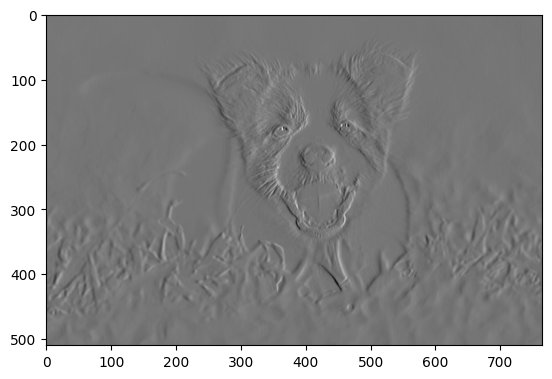

In [7]:
# Convolve the image with the X direction kernel
conv_out_x = F.conv2d(img_tensor.unsqueeze(0), gx, bias=None, stride=1)
print(conv_out_x.shape)

_ = plt.imshow(torch.squeeze(conv_out_x), cmap='gray')

torch.Size([1, 1, 510, 765])


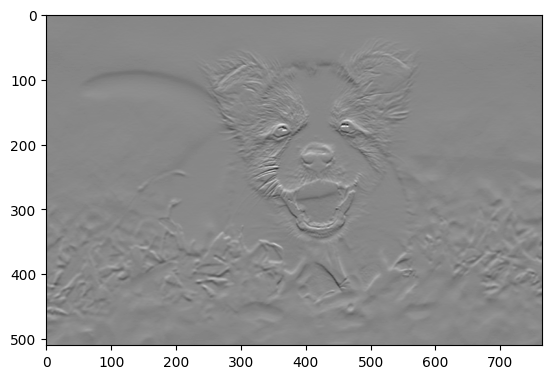

In [8]:
conv_out_y = F.conv2d(img_tensor.unsqueeze(0), gy, bias=None, stride=1)
print(conv_out_y.shape)

_ = plt.imshow(torch.squeeze(conv_out_y), cmap='gray')

torch.Size([1, 1, 510, 765])


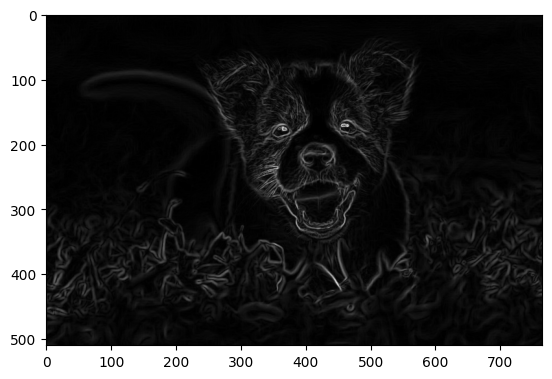

In [10]:
conv_out = (conv_out_x**2 + conv_out_y**2).sqrt()
print(conv_out.shape)

_ = plt.imshow(torch.squeeze(conv_out), cmap='gray')

torch.Size([2, 3, 3, 3])
torch.Size([1, 510, 765])


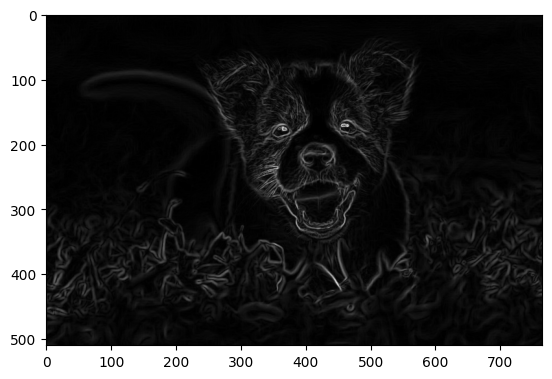

In [26]:
g_xy = torch.cat((gx, gy), 0)

print(g_xy.shape)

conv_out_xy = F.conv2d(img_tensor.unsqueeze(0), g_xy, bias=None, stride=1)
conv_out_xy_mag = conv_out_xy.pow(2).sum(1).sqrt()

_ = plt.imshow(torch.squeeze(conv_out_xy_mag), cmap='gray')

**Train a Convolution Kernel**

In [12]:
# https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html
# torch.nn.Conv2d

# Lets create a learnable 2D convolutional layer
# in_channels  - the number of input channels
# out_channels - the number of output channels - also the number of kernels in a layer
# kernel_size  - the height and width of our kernel - can specify with a tuple for non-square kernels
# stride       - the number of pixels the kernel will "step"
# bias         - same as a linear layer, 1 bias term per output channel

conv_kernel = nn.Conv2d(
    in_channels = 3,
    out_channels = 1,
    kernel_size = 3,
    stride = 1,
    padding = 1,
    bias = False
)

optimizer = optim.SGD(conv_kernel.parameters(), lr = 1e-2)

conv_kernel.weight.shape

torch.Size([1, 3, 3, 3])

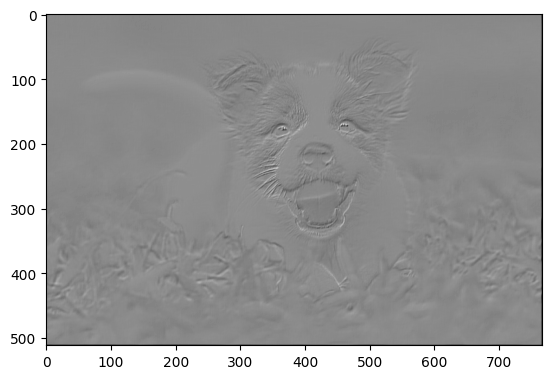

In [29]:
with torch.no_grad():
    imgs_out = conv_kernel(img_tensor.unsqueeze(0))

_ = plt.imshow(imgs_out[0, 0], cmap='gray')

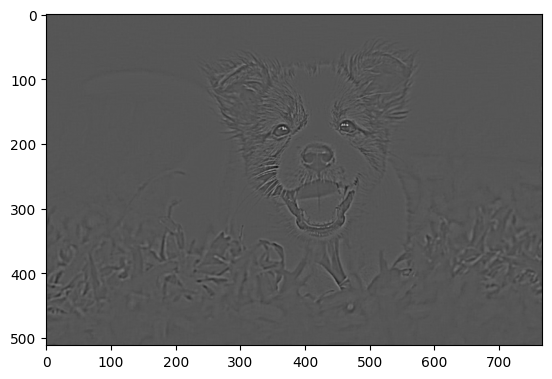

In [30]:
blur = T.GaussianBlur(7, 4)
# Blur the image and subtract this from the original
# Blurring will leave only the high frequency components on the image
# By subtracting them from the original we should get only the high frequency components
target = img_tensor.unsqueeze(0) - blur(img_tensor.unsqueeze(0))
_ = plt.imshow(torch.squeeze(target[0, 0]), cmap='gray')

In [31]:
logger = []

for i in trange(2000):
    imgs_out = conv_kernel(img_tensor.unsqueeze(0))

    loss = (target - imgs_out).pow(2).mean()
    logger.append(loss.item())

    conv_kernel.zero_grad()
    loss.backward()
    optimizer.step()

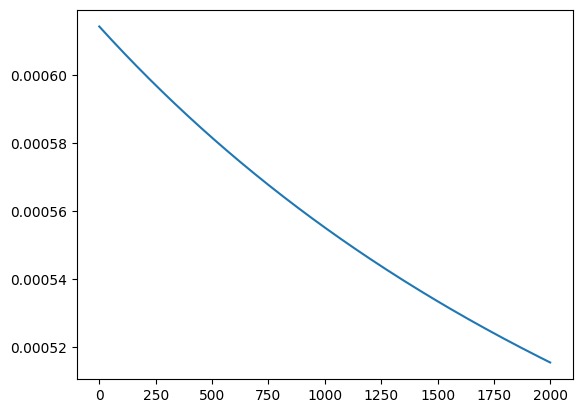

In [36]:
plt.plot(logger)

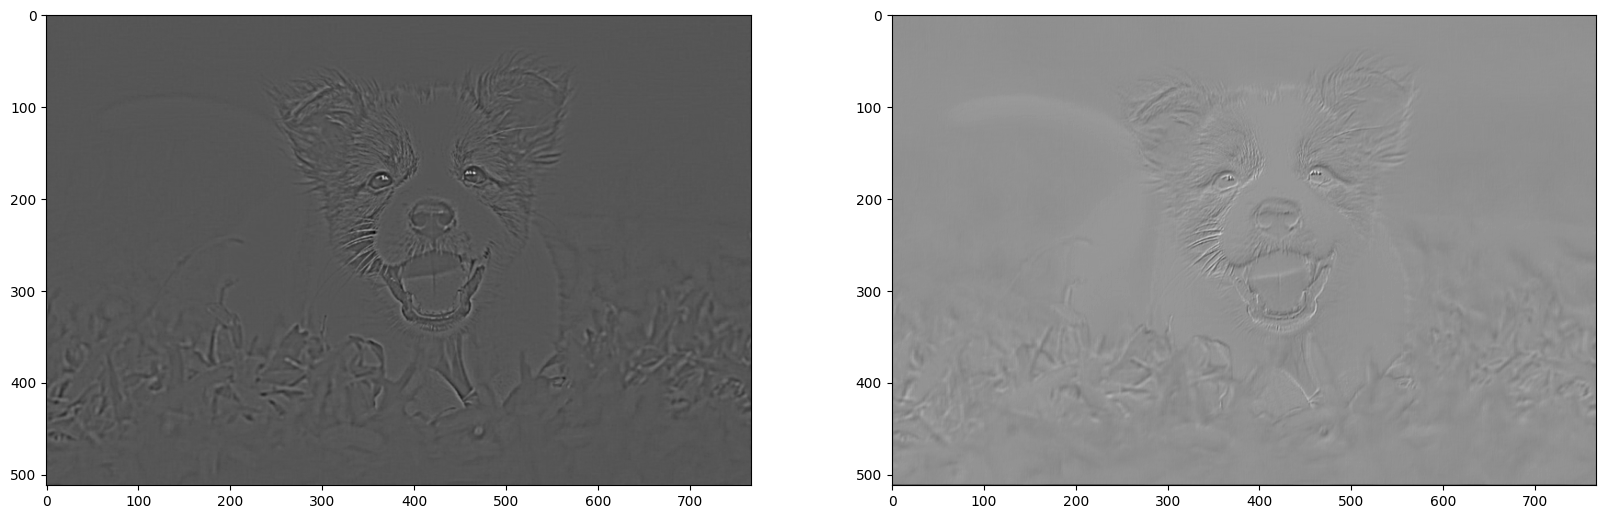

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize = (20,10))
ax1.imshow(torch.squeeze(target[0, 0]), cmap='gray')
ax2.imshow(torch.squeeze(imgs_out[0, 0].detach()), cmap='gray')

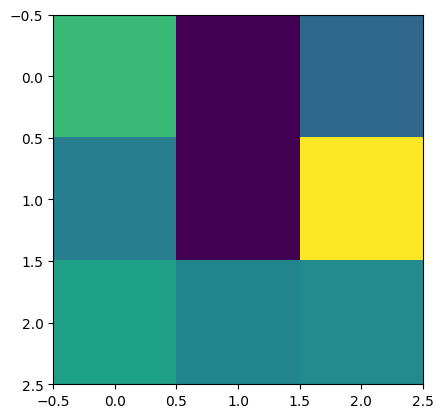

In [37]:
plt.imshow(conv_kernel.weight.data[0].mean(0).numpy())